# Prepare the data

In [1]:
!pip install seaborn --upgrade

     |████████████████████████████████| 293 kB 4.3 MB/s eta 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.10.0
    Uninstalling seaborn-0.10.0:
      Successfully uninstalled seaborn-0.10.0
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
import re
import os
sns.set()
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
warnings.filterwarnings("ignore")

sns.__version__

'0.12.2'

In [9]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/d/erturularslan/marketing-data/marketing_data.csv
/kaggle/input/marketing-data/ifood_df.csv
/kaggle/input/marketing-data/dictionary.png


Let's import our data.

In [10]:
data = pd.read_csv('/kaggle/input/d/erturularslan/marketing-data/marketing_data.csv', index_col='ID', parse_dates=['Dt_Customer'])

data = data.rename(columns={
    'Dt_Customer':'Enrollment date',
    'Recency':'Days since last purchase',
    ' Income ':'Income'})

data['ID'] = data.index

data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Enrollment date,Days since last purchase,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,ID
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1826,1970,Graduation,Divorced,"$84,835.00",0,0,2014-06-16,0,189,104,379,111,189,218,1,4,4,6,1,0,0,0,0,0,1,0,SP,1826
1,1961,Graduation,Single,"$57,091.00",0,0,2014-06-15,0,464,5,64,7,0,37,1,7,3,7,5,0,0,0,0,1,1,0,CA,1
10476,1958,Graduation,Married,"$67,267.00",0,1,2014-05-13,0,134,11,59,15,2,30,1,3,2,5,2,0,0,0,0,0,0,0,US,10476
1386,1967,Graduation,Together,"$32,474.00",1,1,2014-05-11,0,10,0,1,0,0,0,1,1,0,2,7,0,0,0,0,0,0,0,AUS,1386
5371,1989,Graduation,Single,"$21,474.00",1,0,2014-04-08,0,6,16,24,11,0,34,2,3,1,2,7,1,0,0,0,0,1,0,SP,5371


In [11]:
print('Number of columns :',data.shape[1])
print('Number of records :',data.shape[0])

Number of columns : 28
Number of records : 2240


# Data cleaning

Change "Income" column format from "\\$84,835.00" (String) to 84835.00 (Float) <br>
By replacing comma(",") and "$" with empty string("").

In [12]:
# Another way
data['Income'].str.replace(r'[$,]','')

ID
1826     84835.00 
1        57091.00 
10476    67267.00 
1386     32474.00 
5371     21474.00 
           ...    
10142    66476.00 
5263     31056.00 
22       46310.00 
528      65819.00 
4070     94871.00 
Name: Income, Length: 2240, dtype: object

In [13]:
def extract(x):
    if x is np.nan: return np.nan
    return float(re.sub(r'[$,]', "", str(x)))

data['Income'] = data['Income'].apply(extract)

Create table for each section of data

In [14]:
# Store customer's information
Customers = data.loc[:,:'Days since last purchase'].join(data[['Country']])  

# Store product's information
Products = data.loc[:,'MntWines':'MntGoldProds']     

# Store Purchases' information
Purchases = data.loc[:,'NumDealsPurchases':'NumWebVisitsMonth']    

# Store campaign's information
Campaigns = data.loc[:,'AcceptedCmp3':'AcceptedCmp2']     
Misc = data.loc[:,['Response','Complain']]

Create table for each type of data 

In [15]:
category = data.select_dtypes(include='object')
numeric = data.select_dtypes(exclude='object')

---


## Null values detection and deletion

In [16]:
pd.DataFrame(data.isnull().sum(), columns=['#Null values']).T

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Enrollment date,Days since last purchase,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,ID
#Null values,0,0,0,24,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


There're 24 detectable null values in "Income" column. However, we still need to check for other missing values since sometimes missing values are denoted as, for example, "Unknown" for categorical data or -1 for numerical data. <br>


In [18]:
for f in category.columns:
    print(category[f].value_counts())

Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
YOLO          2
Absurd        2
Name: Marital_Status, dtype: int64
SP     1095
SA      337
CA      268
AUS     160
IND     148
GER     120
US      109
ME        3
Name: Country, dtype: int64


Inspecting each value counts in categorical columns -> there're no more missing value.

In [19]:
df = numeric.describe()

def custom_style(row):
    
    color = 'white'
    if row.name == 'min' or row.name == 'max':
        color = 'darkkhaki'

    return ['background-color: %s' % color]*len(row.values)

df.style.apply(custom_style, axis=1)

,Year_Birth,Income,Kidhome,Teenhome,Days since last purchase,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,ID
count,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.149107,0.009375,5592.159821
std,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.356274,0.096391,3246.662198
min,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2828.250000
50%,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5458.500000
75%,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8427.750000
max,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11191.000000


Inspecting each numerical columns -> There's no weirdly low or high value.


### We can conclude that there are only have missing values in "Income" column

### Outliers <br>
Creating report() function to describe and visualize the numerical data.

In [20]:
def report(feature):
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(16,4)
    fig.suptitle(feature, fontsize=16)
    sns.histplot(data=numeric, x=feature, kde=True, ax=ax[0])
    sns.boxplot(data=numeric, x=feature, ax=ax[1])
    plt.show()

    print(numeric[feature].describe())

I'll create new column named "Age" and "Enroll_at_age" derived from "Year_Birth" and "Enrollment date" respectively.

In [21]:
from datetime import date

Age = date.today().year-numeric['Year_Birth']
numeric.insert(1, 'Age', Age,)

Enroll_at_age = numeric['Enrollment date'].dt.year - numeric['Year_Birth']
numeric.insert(6, 'Enroll_at_age', Enroll_at_age)

Then, print the distribution report for numerical columns.

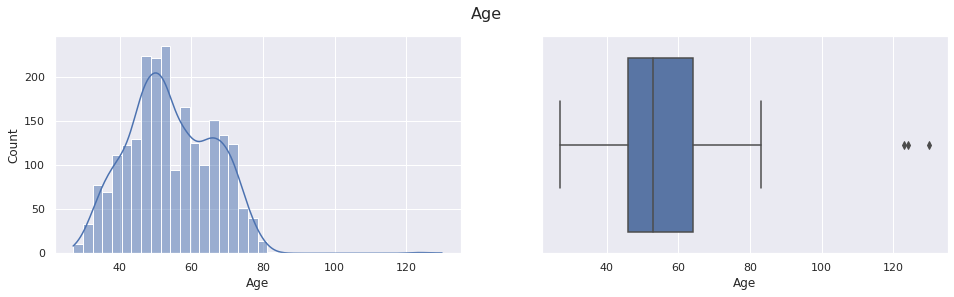

count    2240.000000
mean       54.194196
std        11.984069
min        27.000000
25%        46.000000
50%        53.000000
75%        64.000000
max       130.000000
Name: Age, dtype: float64


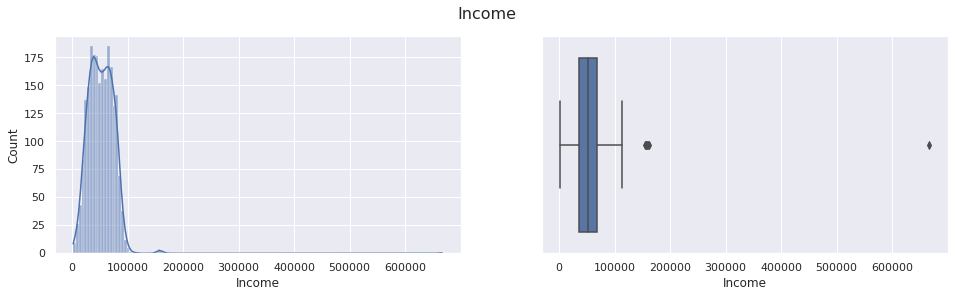

count      2216.000000
mean      52247.251354
std       25173.076661
min        1730.000000
25%       35303.000000
50%       51381.500000
75%       68522.000000
max      666666.000000
Name: Income, dtype: float64


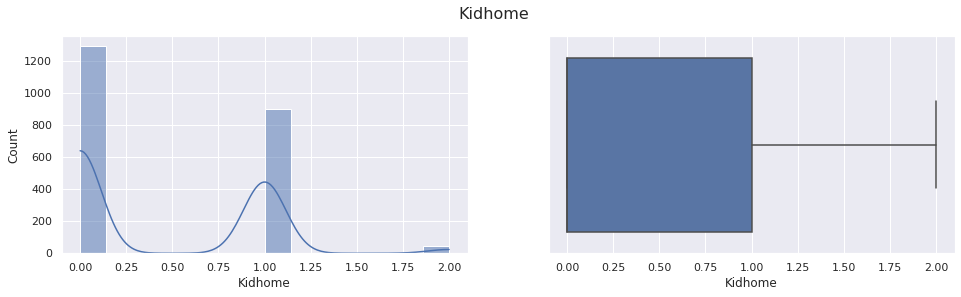

count    2240.000000
mean        0.444196
std         0.538398
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: Kidhome, dtype: float64


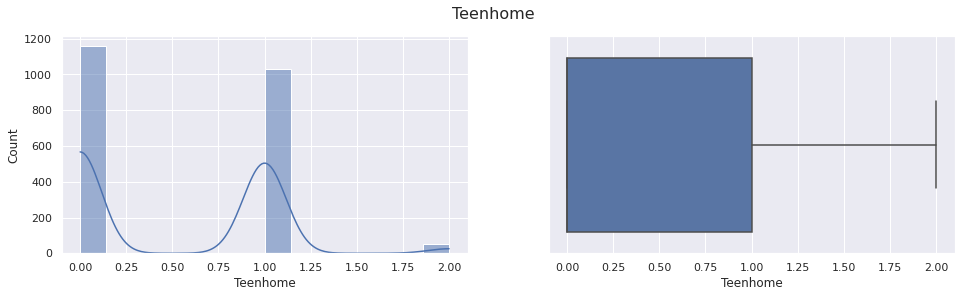

count    2240.000000
mean        0.506250
std         0.544538
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: Teenhome, dtype: float64


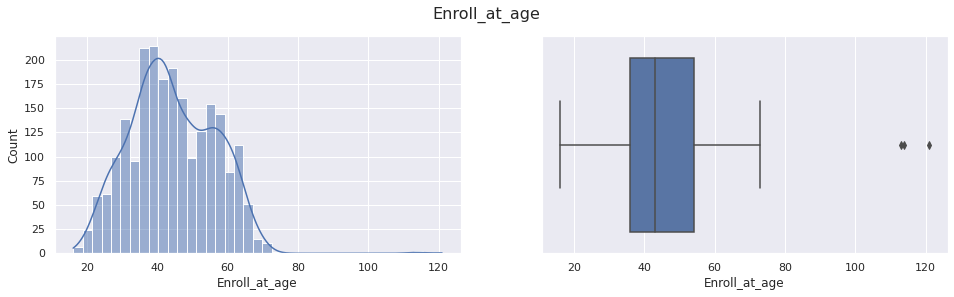

count    2240.000000
mean       44.222321
std        12.022855
min        16.000000
25%        36.000000
50%        43.000000
75%        54.000000
max       121.000000
Name: Enroll_at_age, dtype: float64


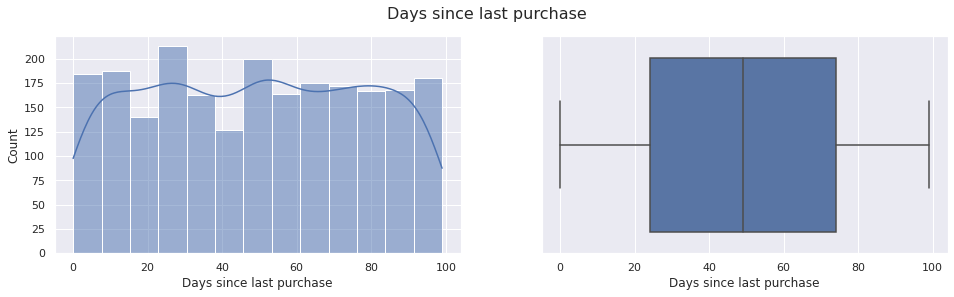

count    2240.000000
mean       49.109375
std        28.962453
min         0.000000
25%        24.000000
50%        49.000000
75%        74.000000
max        99.000000
Name: Days since last purchase, dtype: float64


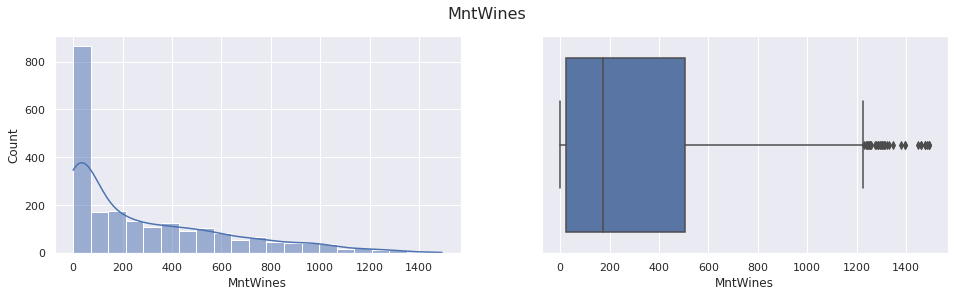

count    2240.000000
mean      303.935714
std       336.597393
min         0.000000
25%        23.750000
50%       173.500000
75%       504.250000
max      1493.000000
Name: MntWines, dtype: float64


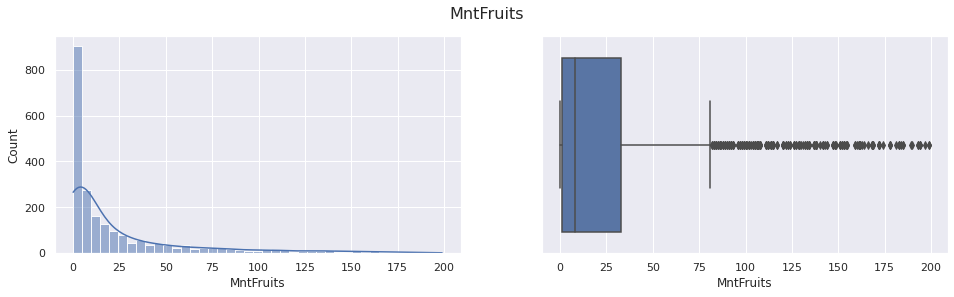

count    2240.000000
mean       26.302232
std        39.773434
min         0.000000
25%         1.000000
50%         8.000000
75%        33.000000
max       199.000000
Name: MntFruits, dtype: float64


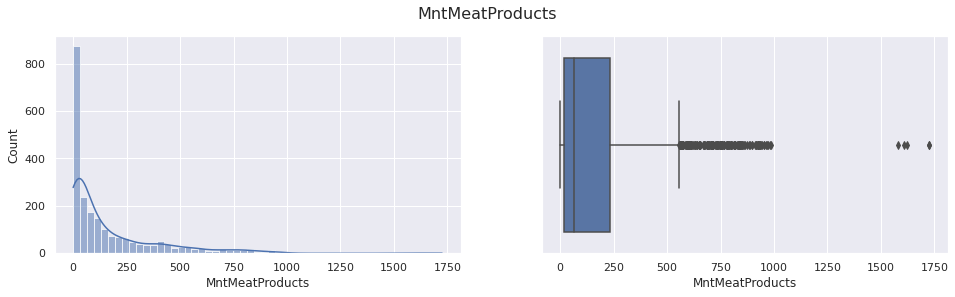

count    2240.000000
mean      166.950000
std       225.715373
min         0.000000
25%        16.000000
50%        67.000000
75%       232.000000
max      1725.000000
Name: MntMeatProducts, dtype: float64


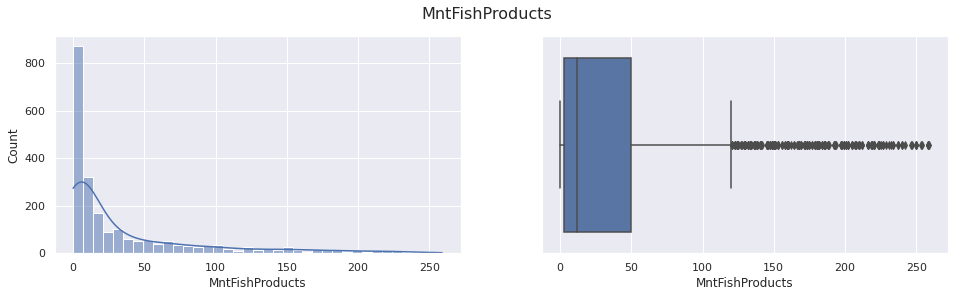

count    2240.000000
mean       37.525446
std        54.628979
min         0.000000
25%         3.000000
50%        12.000000
75%        50.000000
max       259.000000
Name: MntFishProducts, dtype: float64


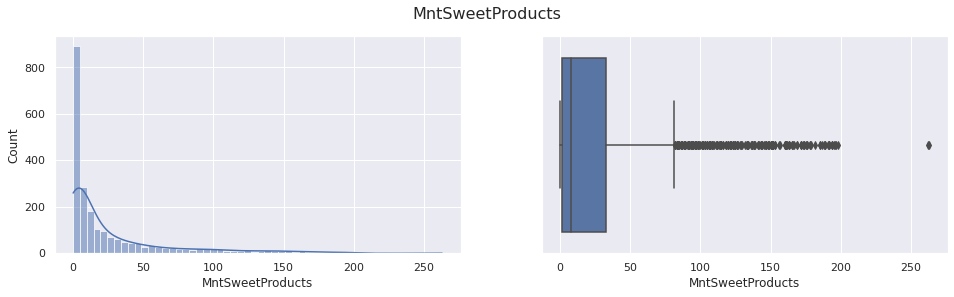

count    2240.000000
mean       27.062946
std        41.280498
min         0.000000
25%         1.000000
50%         8.000000
75%        33.000000
max       263.000000
Name: MntSweetProducts, dtype: float64


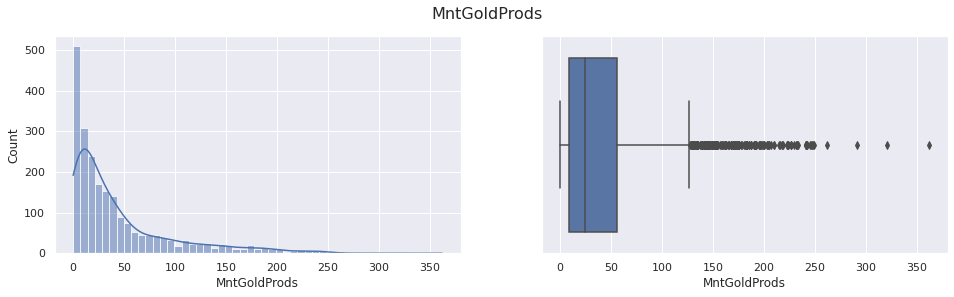

count    2240.000000
mean       44.021875
std        52.167439
min         0.000000
25%         9.000000
50%        24.000000
75%        56.000000
max       362.000000
Name: MntGoldProds, dtype: float64


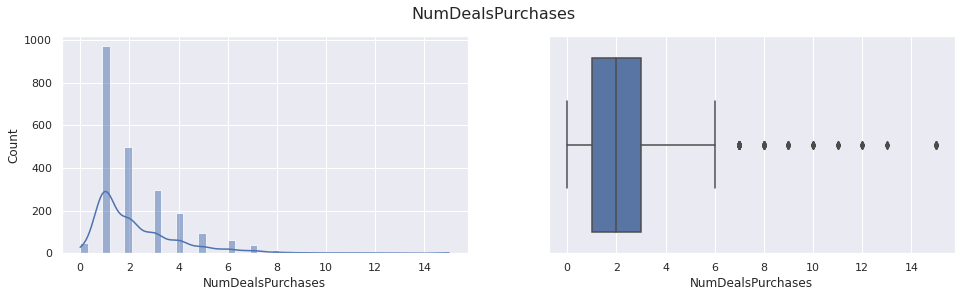

count    2240.000000
mean        2.325000
std         1.932238
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        15.000000
Name: NumDealsPurchases, dtype: float64


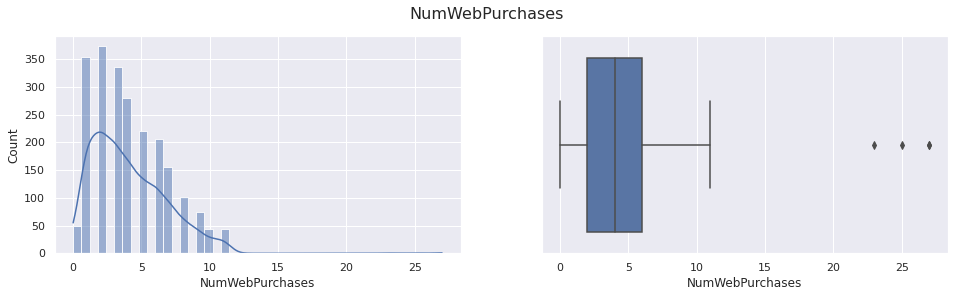

count    2240.000000
mean        4.084821
std         2.778714
min         0.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        27.000000
Name: NumWebPurchases, dtype: float64


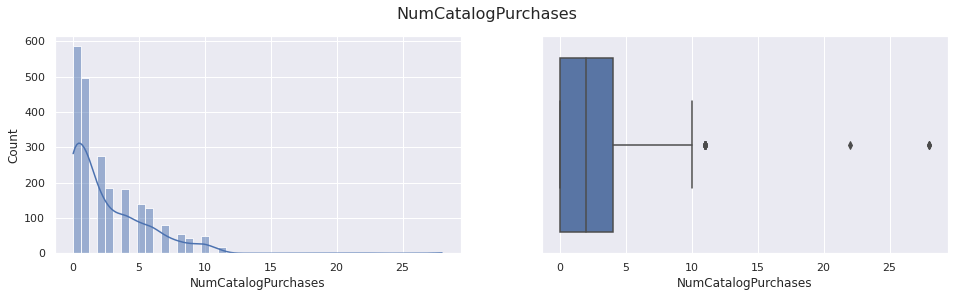

count    2240.000000
mean        2.662054
std         2.923101
min         0.000000
25%         0.000000
50%         2.000000
75%         4.000000
max        28.000000
Name: NumCatalogPurchases, dtype: float64


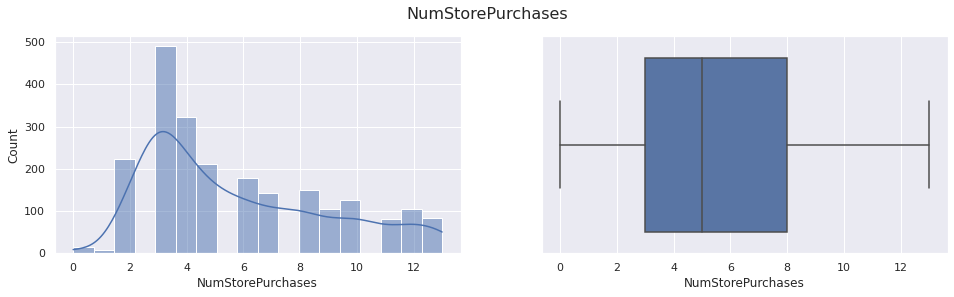

count    2240.000000
mean        5.790179
std         3.250958
min         0.000000
25%         3.000000
50%         5.000000
75%         8.000000
max        13.000000
Name: NumStorePurchases, dtype: float64


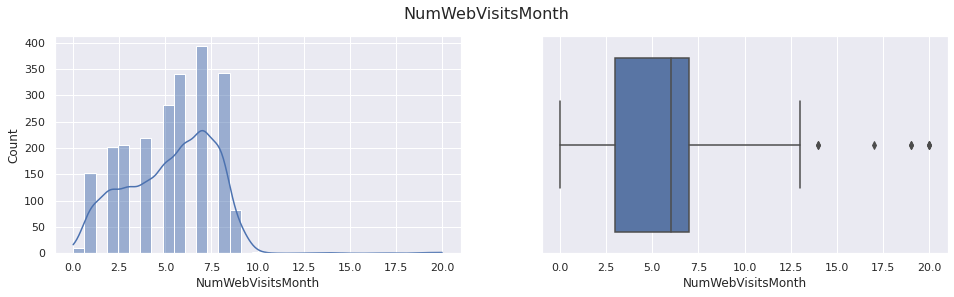

count    2240.000000
mean        5.316518
std         2.426645
min         0.000000
25%         3.000000
50%         6.000000
75%         7.000000
max        20.000000
Name: NumWebVisitsMonth, dtype: float64


In [22]:
for col in numeric.columns:
    if col in ['Year_Birth','Enrollment date']: continue
    if col == 'AcceptedCmp3' : break
    report(col)

After we get some sense of distribution of each numerical column, next, we'll analyze them. <br>
___


**-> Age** <br>
There're 3 people with ages 128, 122, and 121 whose Enrollment_at_age are 113, 114, and 121 respectively which is quite impossible.

In [23]:
numeric[numeric['Age']>80]

,Year_Birth,Age,Income,Kidhome,Teenhome,Enrollment date,Enroll_at_age,Days since last purchase,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,ID
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
11004,1893,130,60182.0,0,1,2014-05-17,121,23,8,0,5,7,0,2,1,1,0,2,4,0,0,0,0,0,0,0,11004
1150,1899,124,83532.0,0,0,2013-09-26,114,36,755,144,562,104,64,224,1,4,6,4,1,0,0,1,0,0,0,0,1150
6932,1941,82,93027.0,0,0,2013-04-13,72,77,1285,42,716,55,0,21,0,7,10,5,2,0,0,1,0,0,0,0,6932
6663,1940,83,51141.0,0,0,2013-07-08,73,96,144,0,7,0,0,6,1,3,1,4,5,0,0,0,0,0,0,0,6663
7829,1900,123,36640.0,1,0,2013-09-26,113,99,15,6,8,7,4,25,1,2,1,2,5,0,0,0,0,0,0,1,7829


In [24]:
temp = numeric[numeric['Age']>120].index
numeric.loc[temp, ["Year_Birth", "Age", "Enroll_at_age"]] = np.nan

**-> Income**

In [25]:
numeric[numeric['Income']>160000]

,Year_Birth,Age,Income,Kidhome,Teenhome,Enrollment date,Enroll_at_age,Days since last purchase,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,ID
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
1501,1982.0,41.0,160803.0,0,0,2012-08-04,30.0,21,55,16,1622,17,3,4,15,0,28,1,0,0,0,0,0,0,0,0,1501
9432,1977.0,46.0,666666.0,1,0,2013-06-02,36.0,23,9,14,18,8,1,12,4,3,1,3,6,0,0,0,0,0,0,0,9432
1503,1976.0,47.0,162397.0,1,1,2013-06-03,37.0,31,85,1,16,2,1,2,0,0,0,1,1,0,0,0,0,0,0,0,1503



**Amount of product, number of purchases features** are exponentially distributed which not unusual. <br>

### 3) Analysis <br>
After we have looked into missing values and outliers, we then analyze all of the features to get some insight into them.

Considering **Enrollment date**, we can see the total number of enrollment in each year in the following bar graph.

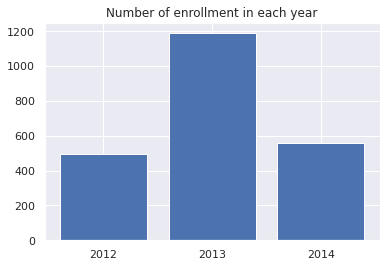

In [26]:
plt.bar(height = numeric['Enrollment date'].dt.year.value_counts()[[2012,2013,2014]], x=['2012','2013','2014'])
plt.title('Number of enrollment in each year')
plt.show()

However in 2012, the data is gathered from 2012/08 and ,in 2014, data is gathered until 2014/07. Thus, that makes sense that 2013 have the greatest number of enrollment. The graph below shows the average number of enrollment over time.

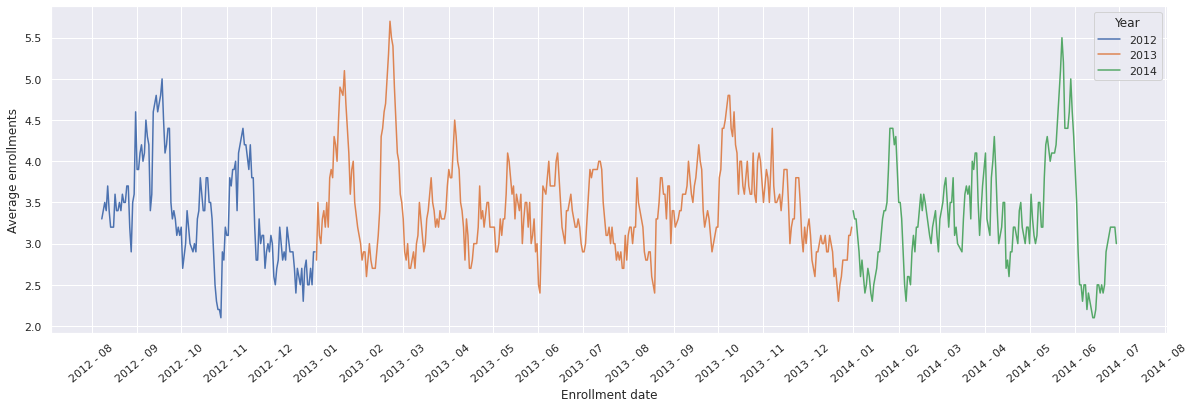

In [27]:
df = pd.pivot_table(numeric, values='ID', index='Enrollment date', aggfunc='count')
df['count'] = df['ID'].rolling(10).mean()
df['Year'] = df.index.year.astype('category')

fig, ax = plt.subplots()
fig.set_size_inches(20,6)

sns.lineplot(data=df, x='Enrollment date', y='count', ax=ax, hue='Year')
ax.set_ylabel('Average enrollments')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y - %m'))
plt.xticks(rotation=40)
plt.show()

## Income <br>
**Mean and Median of Income** in **each country**

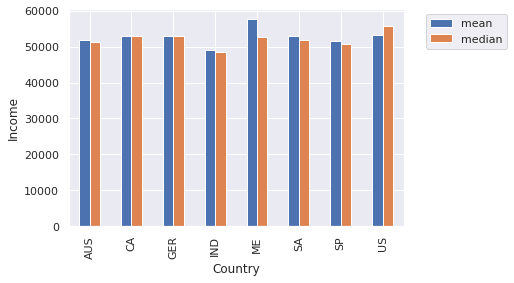

In [28]:
# This time, we need to exclude the outlier in "Income" column before caculating any statistics.
numeric_analysis = numeric[numeric['Income']!=666666]

df = pd.pivot_table(numeric_analysis.join(category[['Country']]), 
                     values='Income', 
                     index='Country', 
                     aggfunc={'Income':['mean','median']})
df.plot(kind='bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Income')
plt.show()

We'll go deeper by looking into relationship between **age** and **income** in **each country**. <br>
We noticed that "ME" country have only 3 observations. We won't drop them. Instead, we'll keep that caution in mind while we're doing analysis.

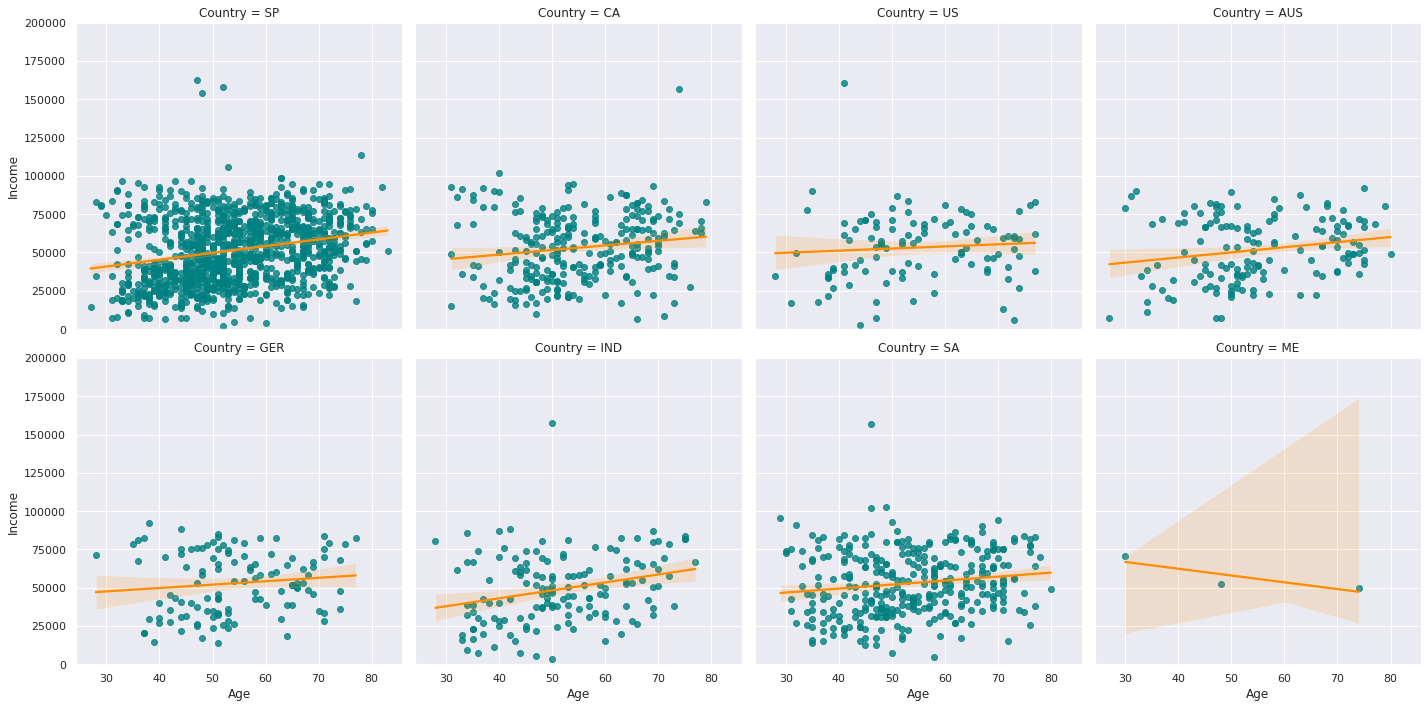

In [29]:
temp = numeric_analysis[['Income','Age']].join(category[['Country']])
sns.lmplot(data=temp, y='Income', x='Age', col='Country', col_wrap=4, line_kws={'color': 'darkorange'}, scatter_kws={'color':'teal'})
plt.ylim(0,200000)
plt.show()

Next, **Income** in each **education level**.

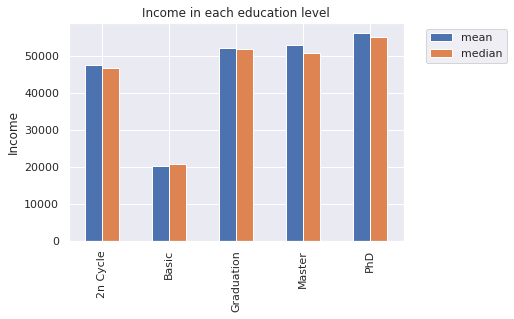

,count,mean,median
Education,,,
2n Cycle,200,47633.190000,46805.0
Basic,54,20306.259259,20744.0
Graduation,1115,52169.749776,51983.0
Master,365,52917.534247,50943.0
PhD,481,56145.313929,55212.0


In [30]:
df = pd.pivot_table(numeric_analysis.join(category[['Education']]), 
               values='Income', 
               index='Education', 
               aggfunc={'Income':['count','mean','median']})

df[['mean','median']].plot(kind='bar')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Income')
plt.xlabel('')
plt.title('Income in each education level')
plt.show()

df

In [31]:
del numeric_analysis

## Purchase

I'll create new column **"Total products amount"** : define a total number of products purchased by each customer.

In [32]:
numeric['Total products amount'] = np.sum(Products, axis=1)

We'll looking into **proportion** of the number of **purchases in each channel** ('Deal', 'Web', 'Catalog', 'Store') to see the performance of each channel. <br>
We see that 39% of all purchase is in store, 27.5% in web, 15.6% in deal, and 17.9% by catalog. We can conclude that ,from the data, more than half of the customers purchased in store and website. 

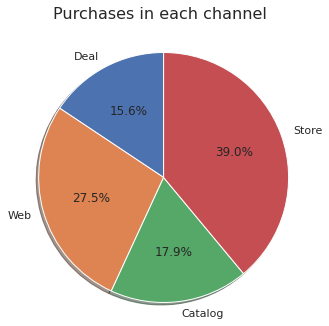

NumStorePurchases      38.959479
NumWebPurchases        27.484906
NumCatalogPurchases    17.911748
NumDealsPurchases      15.643868
dtype: float64


In [33]:
total_purchase_each = np.sum(Purchases.iloc[:,:-1], axis=0)

percent_purchase_each = total_purchase_each/np.sum(total_purchase_each)*100

def plot_pie_chart(labels, sizes: pd.Series, title):
    fig, ax = plt.subplots()
    fig.suptitle(title, fontsize=16)
    fig.set_size_inches(5,5)
    ax.pie(sizes, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax.axis('equal')  
    plt.show()
    print(sizes.sort_values(ascending=False))
    

plot_pie_chart(labels=['Deal','Web','Catalog','Store'], sizes=percent_purchase_each, title='Purchases in each channel')

Next, looking into total number of **purchases** in each **country**. <br>
We see that most of the customers are from Spain

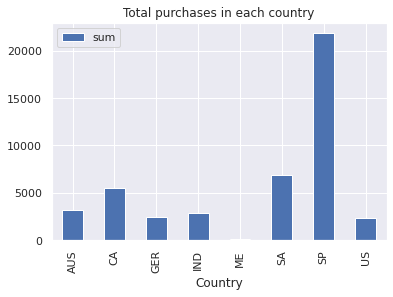

In [34]:
if 'Total purchase' not in Purchases.columns:
    Purchases['Total purchase'] = np.sum(Purchases, axis=1)

Purchase_category = Purchases.join(category)

Purchase_country_summary = pd.pivot_table(Purchase_category, 
                                          values='Total purchase', 
                                          index='Country', 
                                          aggfunc={'Total purchase':['sum']})

Purchase_country_summary.plot(kind='bar')
plt.title('Total purchases in each country')
plt.show()

## Product

 We wanted to know which product was the most popular. So, we'll look into **Overall proportion of products purchased**. <br>
 We see that 50.2% of all products purchased by all customers is wine and the second place(27.6%) is meat.

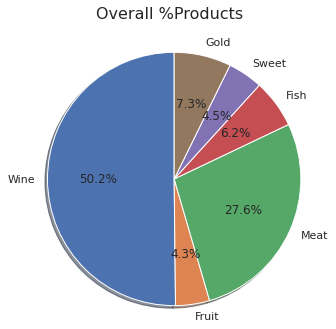

MntWines            50.171114
MntMeatProducts     27.558681
MntGoldProds         7.266755
MntFishProducts      6.194380
MntSweetProducts     4.467320
MntFruits            4.341748
dtype: float64


In [35]:
sum_each_product = np.sum(Products, axis=0)

plot_pie_chart(sizes=sum_each_product/np.sum(sum_each_product)*100, 
               labels=['Wine','Fruit','Meat','Fish','Sweet','Gold'],
              title='Overall %Products')

Moreover, we want to know the average purchase behavior of each customer. We'll looking into **Average proportion of each product purchased by one ID** <br>
From 100% of all product each person puurchased*, we see that 45.8% will be wine, 24.95% meat product, 12% gold ptoduct, 7% fish product, 5% sweet, 4.9% fruit product.

In [36]:
if 'Total' not in Products.columns:
    Products['Total'] = np.sum(Products, axis=1)

Each_ID_Products = Products.apply(lambda x:x/x[-1]*100, axis=1)

Avg_Each_ID_Products = np.mean(Each_ID_Products, axis=0)

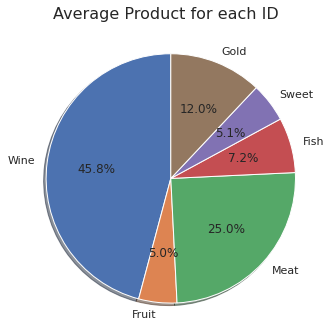

MntWines            45.848136
MntMeatProducts     24.950802
MntGoldProds        12.019649
MntFishProducts      7.153233
MntSweetProducts     5.077723
MntFruits            4.950457
dtype: float64


In [37]:
plot_pie_chart(sizes = Avg_Each_ID_Products[:-1], 
               labels=['Wine','Fruit','Meat','Fish','Sweet','Gold'],
               title='Average Product for each ID')

## Campaign <br>
We wanted to know the performance of each campaign we conducted. Below, the bar graph and pie-chart show the number of acceptance and success rates in each campaign. <br>
We see that camapign2 might have some problems because it's very less accepted while other campaigns are accepted at a similar rate.

In [38]:
each_campaign = np.sum(Campaigns,axis=0)

CR_each_canpaign = each_campaign/len(Campaigns)*100

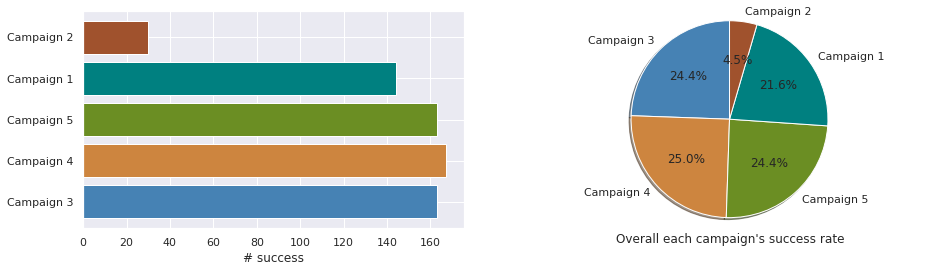

In [39]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(15,4)

cam_color = ['steelblue','peru','olivedrab','teal','sienna']

ax[0].barh(y=['Campaign 3','Campaign 4','Campaign 5','Campaign 1','Campaign 2'], 
           width=each_campaign.values, color=cam_color)
ax[0].set_xlabel('# success')

ax[1].pie(x=CR_each_canpaign, labels=['Campaign 3','Campaign 4','Campaign 5','Campaign 1','Campaign 2'],
         autopct='%1.1f%%', shadow=True, startangle=90, colors=cam_color)
ax[1].axis('equal')
ax[1].set_xlabel('Overall each campaign\'s success rate')

plt.show()

We want to know if 'Age' have some noticeable effect on campaign acceptance. <br>
Although there's no obvious trend, we still can see that campaign3 is likely to be accepted in younger customers than campaign4 while other campaigns are uniformly accepted in different ages.

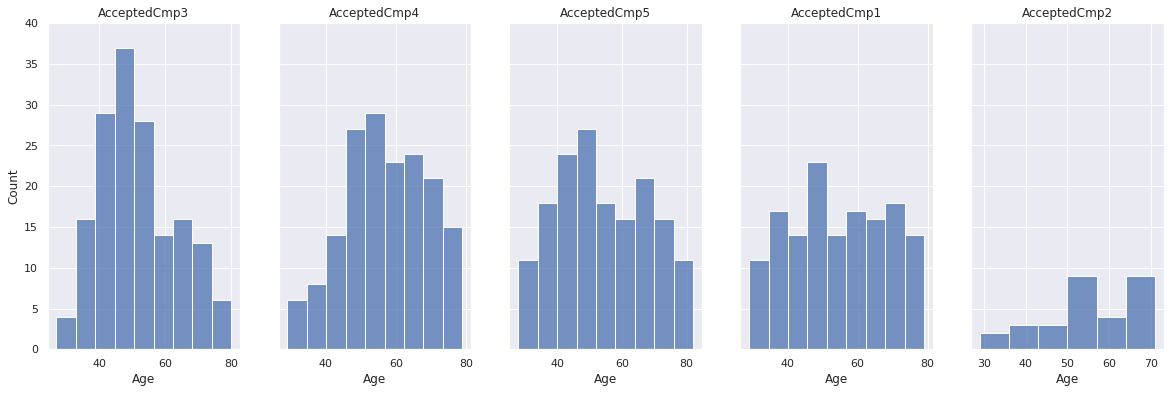

In [40]:
fig, ax = plt.subplots(1,len(Campaigns.columns), sharey=True)
i=0
fig.set_size_inches(20,6)

for campaign in Campaigns.columns:
    sns.histplot(data=numeric[numeric[campaign]==1], x = 'Age', ax=ax[i])
    ax[i].set_ylim(0,40)
    ax[i].set_title(campaign)    
    i+=1
    
plt.show()

Next, we'll see if there's that effect in different countries. The table below shows the **overall conversion rate** in **each country**. <br>

The overall conversion rate is **around 30%**. <br>
We see that '*ME'* has the best conversion rate but there is only 3 observation in this country. So, *it's not significant*. <br>
Other than 'ME', campaigns in **'SP' and 'CA'** get the **best conversion rate(32.4%)**. <br>
The worst rate is in 'AUS' which is 21.8%.

In [41]:
Campaigns_category = Campaigns.join(category)
Campaigns_category['Total accept'] = np.sum(Campaigns, axis=1)

summary_country = pd.pivot_table(Campaigns_category, 
                                   values='Total accept', 
                                   index='Country', 
                                   aggfunc={'Total accept':['sum','count']})

summary_country['CR'] = summary_country['sum']/summary_country['count']
summary_country.rename(columns={'count':'#customers', 'sum':'Total accept'}).style.background_gradient(sns.light_palette('khaki', as_cmap=True), 
                                                                                                       subset=pd.IndexSlice[:, ['CR']])

,#customers,Total accept,CR
Country,,,
AUS,160,35,0.218750
CA,268,87,0.324627
GER,120,38,0.316667
IND,148,39,0.263514
ME,3,1,0.333333
SA,337,86,0.255193
SP,1095,355,0.324201
US,109,26,0.238532


Next, we'll see the **average performance** of **each campaign** in **each country**. <br>
Keep in mind that *\"ME\" has only 3 observations*.

In [42]:
temp = Campaigns_category.groupby(by='Country').agg(['mean'])
temp.drop(['ME'], axis=0, inplace=True)  # since "ME" have only 3 observations, I decided to drop it in this table.
temp.style.background_gradient(sns.light_palette('green', as_cmap=True))

,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Total accept
,mean,mean,mean,mean,mean,mean
Country,,,,,,
AUS,0.056250,0.037500,0.081250,0.043750,0.000000,0.218750
CA,0.067164,0.089552,0.078358,0.067164,0.022388,0.324627
GER,0.083333,0.091667,0.066667,0.058333,0.016667,0.316667
IND,0.087838,0.074324,0.040541,0.047297,0.013514,0.263514
SA,0.062315,0.059347,0.062315,0.059347,0.011869,0.255193
SP,0.075799,0.081279,0.081279,0.071233,0.014612,0.324201
US,0.073394,0.055046,0.045872,0.064220,0.000000,0.238532


In each column, the darkest green shade one is the country that performed the best in each campaign. <br>
We see that:
- In campaign 3, "GER", "IND", "SP", "US" perform quite well.
- In campaign 4, "SP", "IND", "GER", "CA" perform quite well.
- In campaign 5, "AUS", "CA", "SP" perform quite well.
- In campaign 1, "SP", "CA" perform quite well.
- Campaign 2 was doing not very well in any country.
- For the overall average performance, "CA", "GER", "SP" are the best.

# Statistical Analysis

- What **factors** are significantly related to the **number of store purchases?** <br>
I'll figure out this question by trying some feature selection methods including L1-Regularization, ANOVA F-test, Recursive feature elimination.

**First**, We'll see the *linear* effect of numerical variables on "number of store purchases" by using statistical models such as regression and F-test. <br>
But before that we need to immpute the missing values. <br>

I'll impute these null values by KNN imputation. KNN imputation is an approach to fill the missing data by using a model to predict the missing values. A range of different models can be used, although a simple k-nearest neighbor (KNN) model has proven to be effective in experiments. The use of a KNN model to predict or fill missing values is referred to as “Nearest Neighbor Imputation” or “KNN imputation.” <br>

[this link](https://machinelearningmastery.com/knn-imputation-for-missing-values-in-machine-learning/) provides you a great stuff about KNN imputation. Make sure you check it out!

In [43]:
# Building analysis dataset
numeric_analsis = numeric[numeric['Income']!=666666]

# Let's clear redundant features
X_numeric = numeric_analsis.drop(['NumStorePurchases','Enrollment date','Year_Birth','ID','Total products amount'], axis=1)

# Focus on number of store purchases
y = numeric_analsis[['NumStorePurchases']]

In [44]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import f_regression, f_classif, chi2, RFE, VarianceThreshold, SelectPercentile
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.impute import KNNImputer

# 1) Preoprocess
# Impute null values
Imputer = KNNImputer(missing_values=np.nan)

# Standardize numeric columns
Scaler = StandardScaler()

numeric_pipe = Pipeline([("Impute", Imputer),
                         ("Scale", Scaler)])

X_numeric_preprocessed = numeric_pipe.fit_transform(X_numeric)

# 2) Building the models
lasso = Lasso(alpha=0.01).fit(X_numeric_preprocessed, y)
ridge = Ridge().fit(X_numeric_preprocessed, y)
F, p = f_regression(X_numeric_preprocessed, y)  # Statistically check how each predictor & target are linearly correlated

The table below shows a summary of the models we have built. LASSO's coefficient and F-value can tell the importance of each variable. <br>
I also included the variance of each variable to see the spread of value in each variable.

In [45]:
index = [
    ['Features','Variance','Lasso','Ridge','F-test','F-test'],
    ['','','Coef','Coef','F-value','p-value']
]

StorePurchases_effect_num = pd.DataFrame(list(zip(X_numeric.columns,
                                          X_numeric.var()/np.nanmean(X_numeric, axis=0),
                                          lasso.coef_, 
                                          ridge.coef_[0], 
                                          F, p))
                                          ,columns=index).set_index('Features')

StorePurchases_effect_num.sort_values(by=('F-test','p-value')).style.background_gradient(sns.light_palette('khaki', as_cmap=True), 
                                                                                                       subset=pd.IndexSlice[:, [('Lasso','Coef'),
                                                                                                                                ('Ridge','Coef'),
                                                                                                                                ('F-test','F-value')]])

For simplicity, we plot the **coefficient of LASSO** and **F-value of F-test** in the bar graphs below.

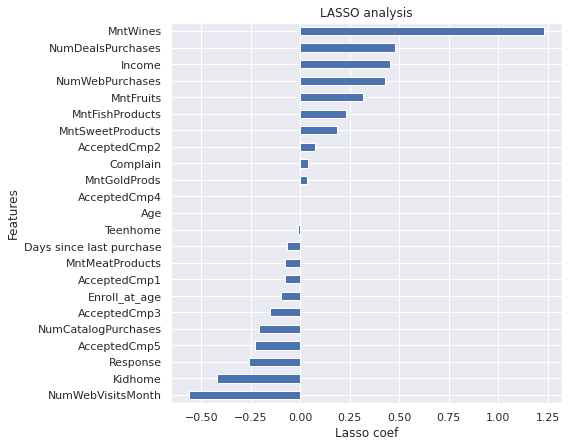

In [46]:
plt.figure(figsize=(7,7))
StorePurchases_effect_num['Lasso']['Coef'].sort_values().plot(kind='barh')
plt.xlabel('Lasso coef')
plt.title('LASSO analysis')
plt.show()

Considering Lasso coefficient, we see that 
- Features having positive effect to the number of store purchases in decreasing order is *'MntWines', 'NumDealsPurchases', 'NumWebPurchases', 'MntFruits', 'MntFishProducts'*.
- Features having negative effect to the number of store purchases in decreasing order is *NumWebVisitsMonth, Kidhome, Response*.

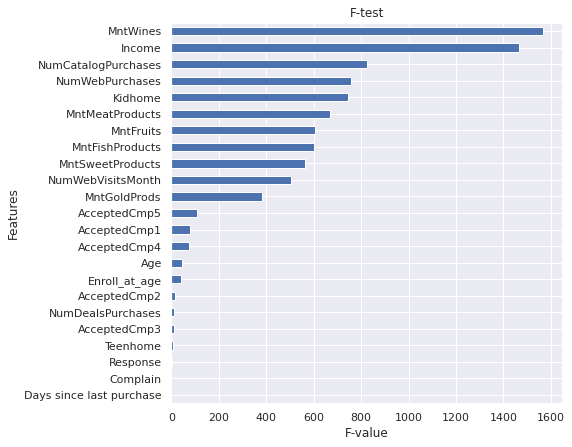

In [47]:
plt.figure(figsize=(7,7))
StorePurchases_effect_num['F-test']['F-value'].sort_values().plot(kind='barh')
plt.xlabel('F-value')
plt.title('F-test')
plt.show()

Apart from statistical methods(LASSO and F-test) that measure te linear effect, we'll also perform Recursive Feature Elimination which is a feature selection method based on ML.

In [48]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

rfe = RFE(estimator = rf, n_features_to_select = 1.0, verbose=1).fit(X_numeric_preprocessed, y)

Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 features.
Fitting estimator with 19 features.
Fitting estimator with 18 features.
Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.


In [49]:
pd.Series(dict(zip(X_numeric.columns, rfe.ranking_)), name='Rank').to_frame().sort_values(by='Rank')

,Rank
MntWines,1
MntMeatProducts,2
Income,3
MntFruits,4
MntGoldProds,5
MntSweetProducts,6
MntFishProducts,7
Days since last purchase,8
NumCatalogPurchases,9
Age,10


We can conclude from many methods we performed before that **'MntWines' is the most significant factor related to the number of store purchases.**

Once we see the effect of our numerical variables on the number of store purchases, we also have to see the effect of categorical variables.<br>

In [50]:
category_NumStore = numeric[['NumStorePurchases']].join(category)
category_NumStore.head()

,NumStorePurchases,Education,Marital_Status,Country
ID,,,,
1826,6,Graduation,Divorced,SP
1,7,Graduation,Single,CA
10476,5,Graduation,Married,US
1386,2,Graduation,Together,AUS
5371,2,Graduation,Single,SP


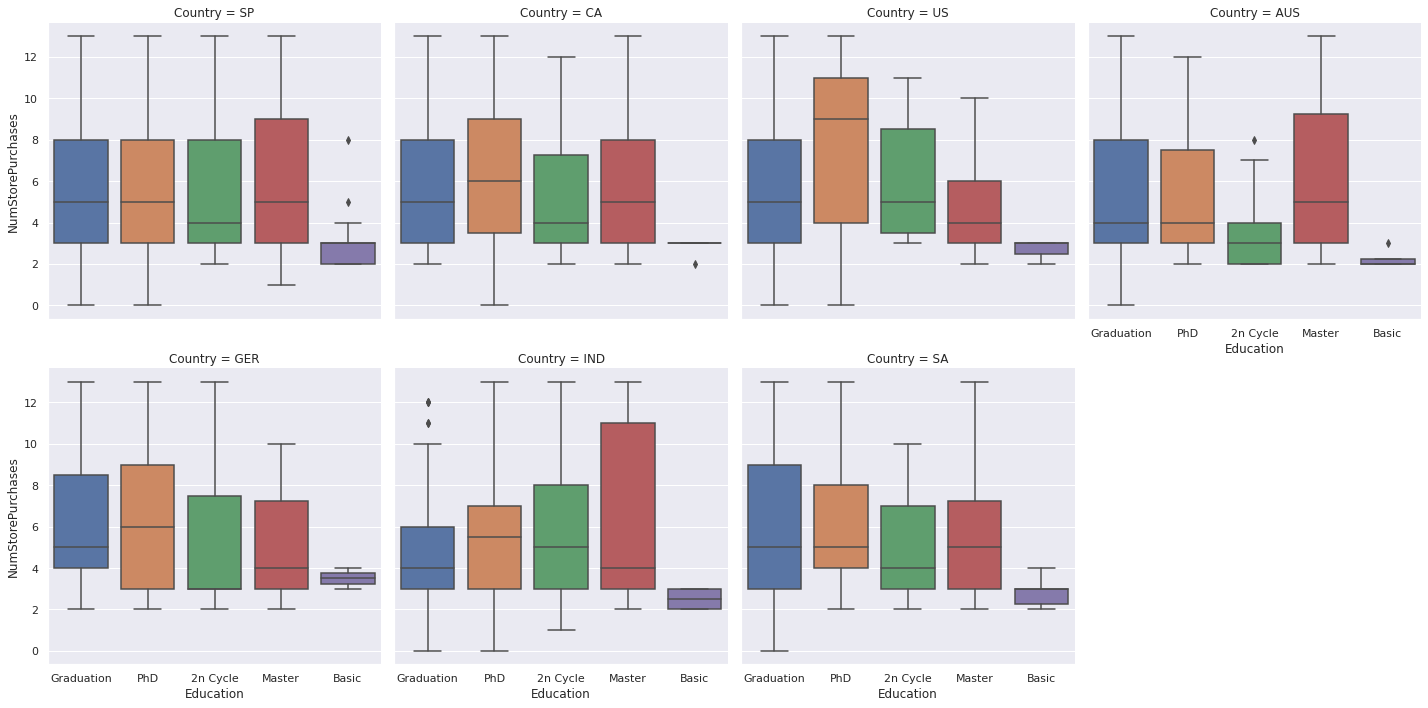

In [51]:
sns.catplot(kind='box', data=category_NumStore.query("Country!='ME'"), col='Country', x='Education', y='NumStorePurchases',  col_wrap=4)
plt.show()

Obviously, we can see that **'Basic' education level** seems to have **the lowest number of store purchases in all countries**. 

On the other hand, there is no obvious trend in marital status in each country as shown in the plot below. However, from the plot below, we might conclude that **widows in the US** are **less likely to purchase in-store** while those in AUS, IND, GER are tended to purchase in-store.

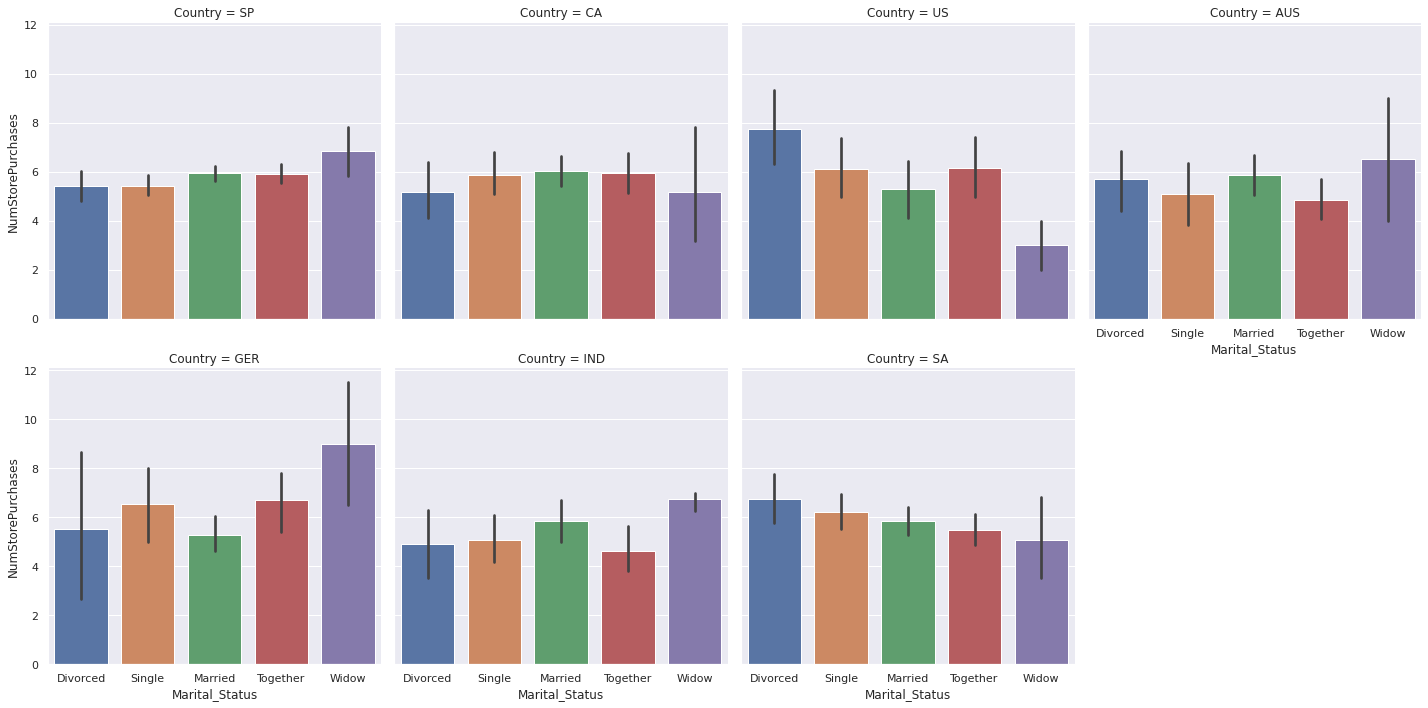

In [52]:
sns.catplot(kind='bar', data=category_NumStore.query("(Country!='ME') and (Marital_Status not in ['YOLO','Alone','Absurd'])"), 
            col='Country', x='Marital_Status', y='NumStorePurchases',  col_wrap=4)
plt.show()

Lastly, we have to look up to the average number of store purchases in each country and in each education level to see if there's some bias in the number of samples.

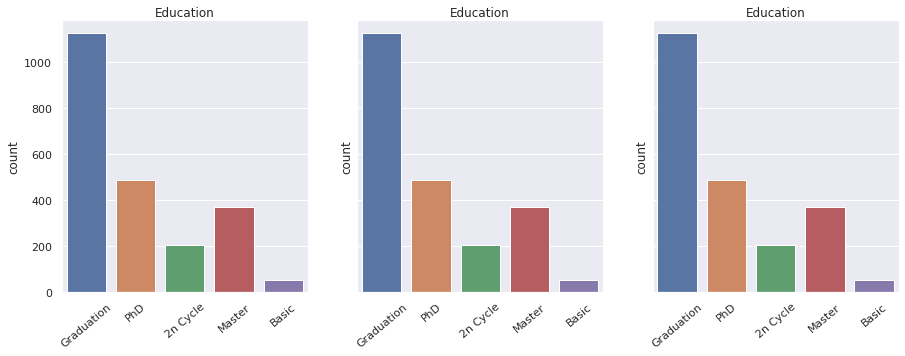

In [53]:
fig, ax = plt.subplots(1,3, sharey=True)
fig.set_size_inches(15,5)

for i,col in list(enumerate(['Education', 'Marital_Status', 'Country'])):
    sns.countplot(data=data, x='Education',  ax=ax[i])

for ax_i in ax:
    ax_i.xaxis.set_label_coords(0.5, 1.05)
    plt.setp( ax_i.xaxis.get_majorticklabels(), rotation=40 )

plt.show()

We can't confidentially tell that **'Basic' education level** have **the lowest number of store purchases in all countries** because we don't have enough data to say so. But these visualization give us a roughly say. If we have more data, we'll have more confident to that.

- Does **US** fare significantly better than the Rest of the World in terms of **total purchases?** <br>

I'll do **X-test** to test whether mean of total purchases in US is significantly higher than other country by stating null-hypothesis and alternative hypothesis under the significance level of 0.05 as following.<br>
In each country : $C$ <br>
$H_0 : \mu_{us} \leq \mu_{c}$ <br>
$H_a : \mu_{us} > \mu_{c}$
$, \alpha = 0.05$

Let's see the distribution of purchases in each country and then <br>
a table that summary important statistics of purchases in each country.

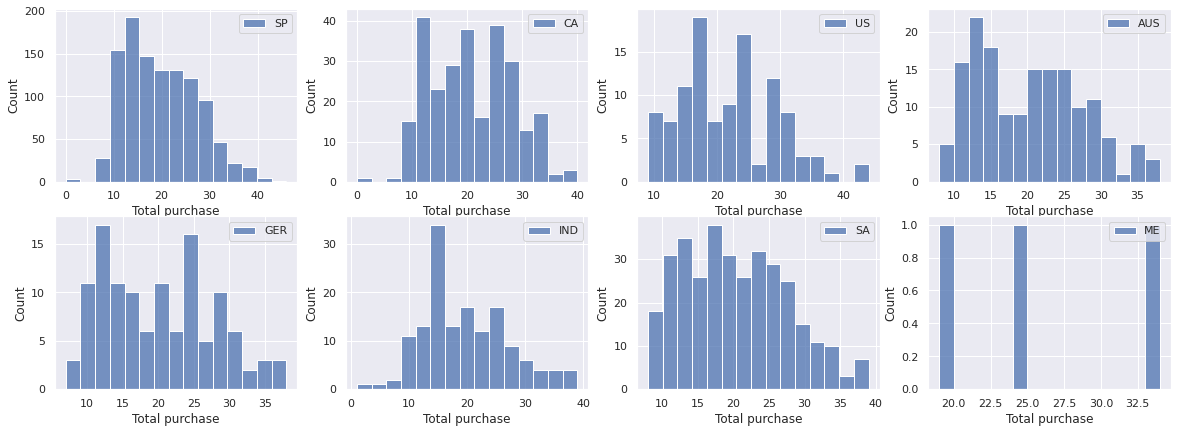

In [54]:
temp = Purchases.join(data[['Country','ID']])

fig, ax = plt.subplots(2,4)
fig.set_size_inches(20,7)
i=0

import itertools 
axes = list(itertools.chain(ax[0],ax[1]))

for c in temp.Country.unique():
    sns.histplot(data=temp[temp['Country'] == c], x='Total purchase', label=c, ax=axes[i], bins=15)
    axes[i].legend()
    i+=1
plt.show()

In [55]:
summary_purchase_country = np.sum(Purchases, axis=1).to_frame('Total purchases').join(category[['Country']]).groupby(by='Country').agg(['count','sum','mean','median','std'])

summary_purchase_country

Total purchases                                    
                  count    sum       mean median        std
Country                                                    
AUS                 160   6282  39.262500     40  14.302433
CA                  268  11036  41.179104     40  14.859568
GER                 120   4818  40.150000     40  14.935520
IND                 148   5826  39.364865     36  14.704411
ME                    3    154  51.333333     48  15.275252
SA                  337  13798  40.943620     40  14.099976
SP                 1095  43744  39.948858     38  14.562641
US                  109   4742  43.504587     42  15.227062

In [56]:
from scipy.stats import norm

US_mean = summary_purchase_country.loc['US', ('Total purchases','mean')]
US_std = summary_purchase_country.loc['US', ('Total purchases','std')]
US_n = summary_purchase_country.loc['US', ('Total purchases','count')]

for country in summary_purchase_country.index:
    if country == 'US':break
    other_mean = summary_purchase_country.loc[country, ('Total purchases','mean')]
    x = (US_mean-other_mean)/(US_std/US_n**0.5)
    print('mean "US" > mean "'+country.upper()+'" p-value = '+str(norm.sf(x)))
    

mean "US" > mean "AUS" p-value = 0.001815537848326719
mean "US" > mean "CA" p-value = 0.055417908161260694
mean "US" > mean "GER" p-value = 0.010722851660792366
mean "US" > mean "IND" p-value = 0.0022672597368808955
mean "US" > mean "ME" p-value = 0.9999999601295373
mean "US" > mean "SA" p-value = 0.03955227838776489
mean "US" > mean "SP" p-value = 0.007385297396392279


If we ignore "ME", because of its too few observation, we still can not conclude that US has significantly better than the Rest of the World in term of total purchase since p-value of $\mu_{us}>\mu_{ca}$ is 0.0554 which is not less than 0.05.

- people who spent an above average amount on gold in the last 2 years would have more in store purchases.

From the histogram and boxplot below, we can conclude that people who spent an **above-average amount on gold** have more **in-store purchases**.

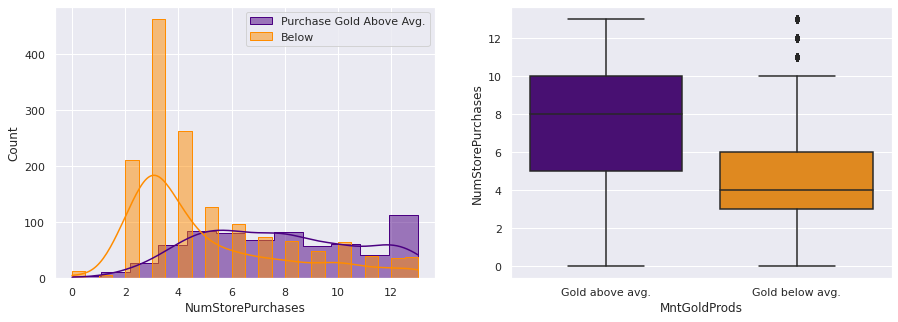

In [57]:
Gold_avg = np.mean(Products['MntGoldProds'])

mask = Products['MntGoldProds']>=Gold_avg

Above_gold = Products[mask].index
Below_gold = Products[~mask].index

fig,ax = plt.subplots(1,2)
fig.set_size_inches(15,5)
sns.histplot(ax=ax[0], data=Purchases[mask], x='NumStorePurchases', kde=True, label='Purchase Gold Above Avg.', color='indigo',element='step')
sns.histplot(ax=ax[0], data=Purchases[~mask], x='NumStorePurchases', kde=True, label='Below', color='darkorange', element='step')

temp = Purchases.join(mask)
temp['MntGoldProds'] = temp['MntGoldProds'].replace({True:'Gold above avg.', False:'Gold below avg.'})
sns.boxplot(ax=ax[1], data=temp, y='NumStorePurchases', x='MntGoldProds', palette={'Gold above avg.':'indigo','Gold below avg.':'darkorange'})

ax[0].legend()
plt.show()

- do **"Married PhD candidates"** have a significant relation with amount spent on **fish**? What other factors are significantly related to amount spent on fish?

In [58]:
PhD_Married = (category['Education']=='PhD') & (category['Marital_Status']=='Married')

numeric.loc[PhD_Married,['MntFishProducts']].describe().join(numeric.loc[~PhD_Married,['MntFishProducts']].describe(),
                                                            lsuffix='_PhD&Marrid',
                                              
                                                            rsuffix='_Not')

,MntFishProducts_PhD&Marrid,MntFishProducts_Not
count,192.000000,2048.000000
mean,27.015625,38.510742
std,41.997940,55.572773
min,0.000000,0.000000
25%,0.000000,3.000000
50%,4.000000,12.000000
75%,38.000000,50.250000
max,193.000000,259.000000


From the summary table above, we clearly see that "Married PhD candidates" doesn't have a significant relation with amount spent on fish. <br>

So, what is the key factor related to amount spent on fish? Let's first see the correlation between other numerical features and 'MntFishProducts'.

In [59]:
Customers.drop(['Year_Birth','Enrollment date'], axis=1)\
.join([Purchases, Products, Campaigns])\
.corr()[['MntFishProducts']]\
.style.background_gradient(sns.light_palette('green', as_cmap=True))

,MntFishProducts
Income,0.438871
Kidhome,-0.387644
Teenhome,-0.204187
Days since last purchase,0.001079
NumDealsPurchases,-0.139361
NumWebPurchases,0.293681
NumCatalogPurchases,0.534478
NumStorePurchases,0.459855
NumWebVisitsMonth,-0.446003
Total purchase,0.345769


From the correlation table above, the darker the color shade is the greater relation on 'MntFishProducts' each variable has.

Moreover, we need to see if there are some categorical variables that can be related to 'MntFishProducts'.

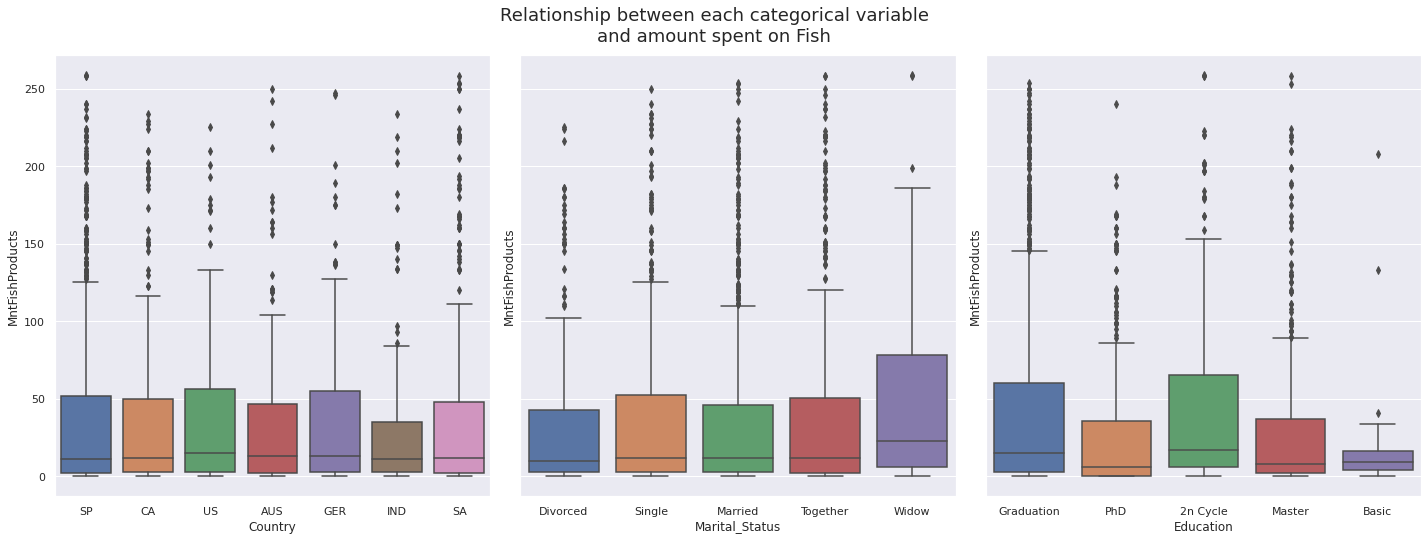

In [60]:
fig, ax = plt.subplots(1,3, sharey=True)
fig.set_size_inches(20,7)
sns.boxplot(data=data[data['Country']!='ME'], 
            x='Country', y='MntFishProducts',
            ax=ax[0])

sns.boxplot(data=data.query('Marital_Status not in  ["YOLO","Alone","Absurd"]'), 
            x='Marital_Status', y='MntFishProducts',
            ax=ax[1])

sns.boxplot(data=data, x='Education', y='MntFishProducts',ax=ax[2])

fig.tight_layout()
fig.suptitle('Relationship between each categorical variable\nand amount spent on Fish', fontsize=18, y=1.07)
plt.show()

From the **"Relationship between each categorical variable and amount spent on Fish"** graphs we see that:
- In 'Country' variable, we see no difference in each country on 'MntFishProducts'.
- In 'Marital_Status' variable, Widow tends to have more 'MntFishProducts'.
- In 'Education' variable, 'Graduation' and '2n Cycle' tends to have more 'MntFishProducts'.

Once we know that 'Marital_Status' and 'Education' have some relation to 'MntFishProducts', we'll go deeper to find more specific insight.

First, see 'Marital_Status' in each country.

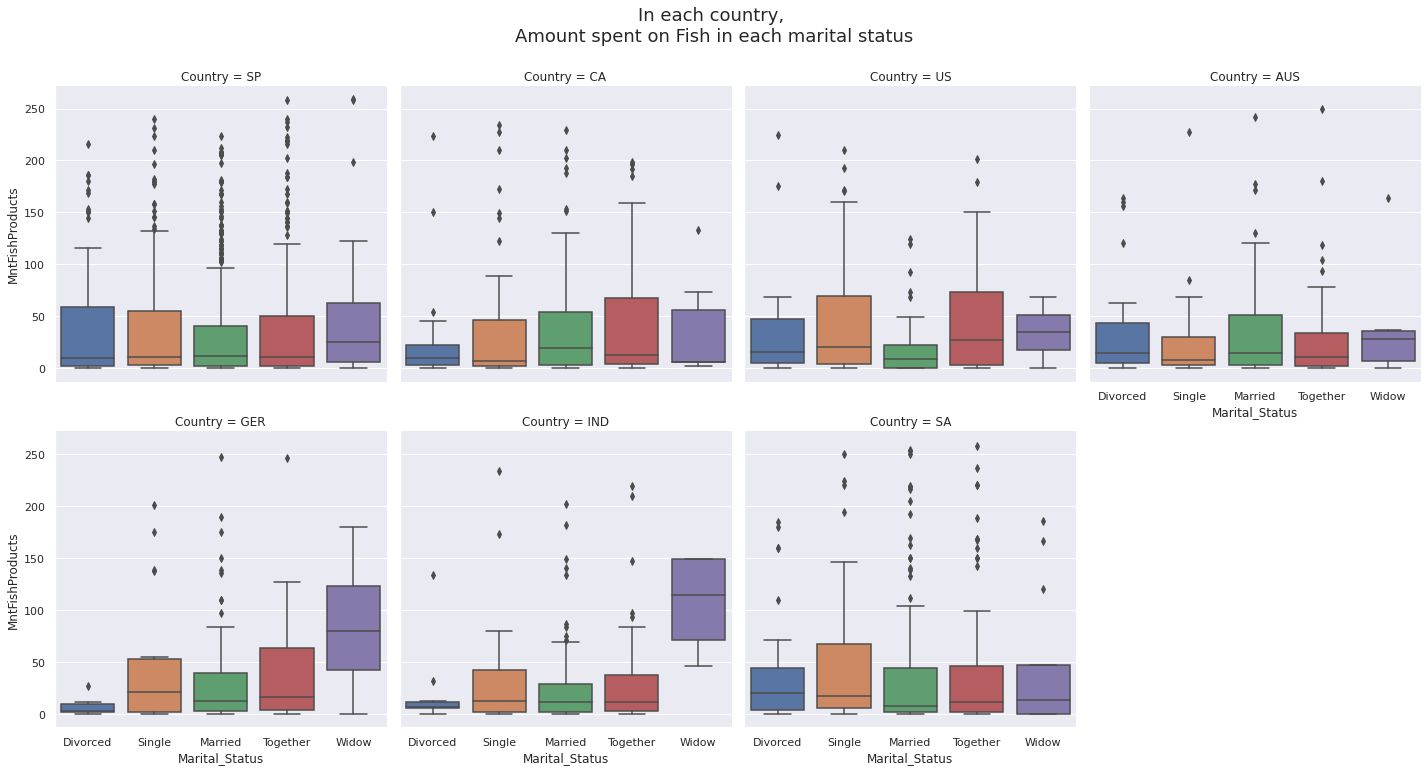

In [61]:
sns.catplot(kind='box', data = data.query('(Marital_Status not in ["YOLO","Absurd","Alone"]) and (Country != "ME")'), 
            x ='Marital_Status', 
            y ='MntFishProducts', 
            col='Country', col_wrap=4)
plt.suptitle('In each country, \nAmount spent on Fish in each marital status', fontsize=18, y=1.07)

plt.show()

From the **"In each country, Amount spent on Fish in each marital status"** graphs we see that:
- **Widows** from **"GER" and "IND"** tend to spend on fish significantly more than others. While the **Divorced** from those country have a opposite trend.

And then, see 'Education' in each country.

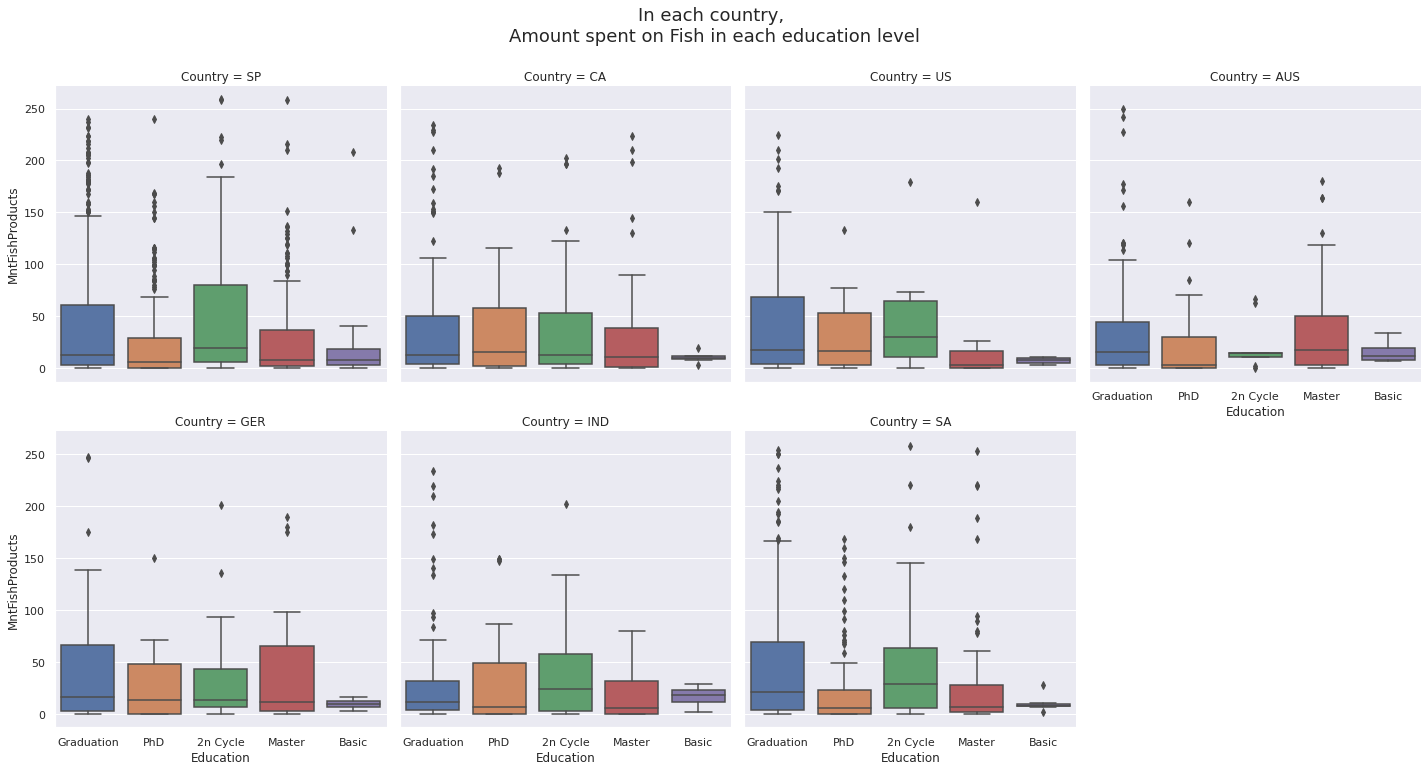

In [62]:
sns.catplot(kind='box', data = data.query('(Marital_Status not in ["YOLO","Absurd","Alone"]) and (Country != "ME")'), 
            x ='Education', 
            y ='MntFishProducts', 
            col='Country', col_wrap=4)
plt.suptitle('In each country, \nAmount spent on Fish in each education level', fontsize=18, y=1.07)

plt.show()

From the **"In each country, Amount spent on Fish in each education level"** graphs we see that:

- Only 'Graduation' and '2n Cycle' in 'SP', 'US', and 'SA' spend on fish more than others. But not for other countries.